In [1]:
import pandas as pd
import csv
import numpy as np

In [ ]:
# ssh wap@192.168.XX.XXX:/Data4/GISAID_Data/20231118/
# cat metadata_enrolled_*.tsv > meta_world_202212_202310.tsv
# rm metadata_enrolled_*.tsv
# scp meta_world_202212_202310.tsv soniali@192.168.14.235:/home/soniali/Desktop/02_china_recom_renew/1_epi/world_china_compare_GISAID/

In [2]:
output_path = dirpath = "/home/soniali/Desktop/02_china_recom_renew/1_epi/world_china_compare_GISAID/"
df = pd.read_csv(dirpath+"meta_world_202212_202310.tsv")
print(df.shape)

(739678, 4)


In [3]:
df

,strain,date,country,lineage
0,EPI_ISL_16651307,2022-12-27,USA,BN.1.5.2
1,EPI_ISL_16651308,2022-12-27,USA,BQ.1
2,EPI_ISL_16651312,2022-12-27,USA,BA.5.2.6
3,EPI_ISL_16651313,2022-12-27,USA,BQ.1.14
4,EPI_ISL_16651314,2022-12-27,USA,BQ.1.2.1
...,...,...,...,...
739673,EPI_ISL_16651279,2022-12-27,USA,BQ.1.1
739674,EPI_ISL_16651283,2022-12-27,USA,BQ.1.15
739675,EPI_ISL_16651285,2022-12-27,USA,BQ.1.1.52
739676,EPI_ISL_16651304,2022-12-27,USA,DT.3


In [4]:
del_index = []
for i in df.index:
    if len(df.loc[i,"date"]) != 10:
        del_index.append(i)

len(del_index)

8885

In [5]:
for i in df.index:
    if {i} - set(del_index) == set():
        df = df.drop(index = i,axis = 1)

In [6]:
df.shape

(730793, 4)

In [7]:
#合并谱系,另存为csv,建立合并与合并前对应的字典。
output_path = "/home/soniali/Desktop/02_china_recom_renew/1_epi/"
lineage_file = "/home/soniali/Desktop/02_china_recom_renew/0_raw_data/representative_lineages.csv"
dict_lineage_hebing = {}
with open(lineage_file) as csvfile:
    csv_reader = csv.reader(csvfile)  
    for row in csv_reader:
        if row[0] != 'Representative_ancestors':
            lineage_after = row[0]
            linaege_before = row[1].replace(' ','').split(',')
            dict_lineage_hebing[lineage_after] = linaege_before

In [8]:
#在上面新建的一列中填入合并后的谱系
df["merged_lineage"] = np.nan
for k,v in dict_lineage_hebing.items():
    for i in v:
        df.loc[(df.lineage == i) ,'merged_lineage'] = k      
        
for i in df.index:
    if df.loc[i,"merged_lineage"] not in set(dict_lineage_hebing.keys()):
        df.loc[i,"merged_lineage"] = "Others"
        

In [11]:
new_df = df.drop('lineage', axis=1)
new_df.to_csv(dirpath+'Qualified_world_china_meta_merged_202212_202310.txt',index = None)

In [10]:
for coun in ["USA","United Kingdom","Japan","China"]:
    china_rows = new_df[new_df['country'] == coun]
    # china_rows['date'] = pd.to_datetime(china_rows['date'])
    china_rows = china_rows.sort_values(by='date')

    first_occurrences = china_rows.drop_duplicates('merged_lineage', keep='first')
    print(coun)
    print(first_occurrences)
    
# lin_list = []


USA
                  strain        date country merged_lineage
475178  EPI_ISL_16115424  2022-12-01     USA         Others
412722  EPI_ISL_16384005  2022-12-01     USA       BA.2.75*
566539  EPI_ISL_16168078  2022-12-01     USA       XBB.1.5*
204281  EPI_ISL_17148425  2022-12-13     USA       BF.7.14*
428484  EPI_ISL_16308151  2022-12-14     USA     BA.5.2.48*
712967  EPI_ISL_18498511  2022-12-31     USA        EG.5.1*
712965  EPI_ISL_18498477  2022-12-31     USA      XBB.1.16*
6416    EPI_ISL_16659601  2023-01-03     USA     XBB.1.9.1*
90944   EPI_ISL_17579726  2023-02-10     USA    XBB.1.22.1*
United Kingdom
                  strain        date         country merged_lineage
480442  EPI_ISL_16072100  2022-12-01  United Kingdom         Others
480454  EPI_ISL_16072071  2022-12-01  United Kingdom       BA.2.75*
472577  EPI_ISL_16142561  2022-12-01  United Kingdom       XBB.1.5*
423415  EPI_ISL_16336147  2022-12-17  United Kingdom     BA.5.2.48*
599321  EPI_ISL_16430229  2022-12-19  Uni

# 运行plot_Ridgeline.r

In [12]:
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib import colorbar

In [13]:
from datetime import *
def date_diff(date1, date2):
    return (date2 - date1).days


df_lin_example  = pd.read_csv(dirpath+'Qualified_world_china_meta_merged_202212_202310.txt')
top8_lineages = ['BA.5.2.48*', 'BF.7.14*', 'BA.2.75*', 'XBB.1.5*', 'XBB.1.9.1*', 'XBB.1.22.1*', 'XBB.1.16*', 'EG.5.1*']
df_lin_example = df_lin_example[df_lin_example["merged_lineage"].isin(top8_lineages)]
# all_country = set(list(df_lin_example.country))
all_country = ["USA","UK","Japan","China"]

country_lin_peaktime = {}
for coun in all_country:
    country_lin_peaktime[coun] = {}

for coun in all_country:
    df_temp0 = df_lin_example[df_lin_example["country"] == coun]
    for lin in top8_lineages:
        df_temp1 = df_temp0[df_temp0["merged_lineage"] == lin]
        df_temp1['date'] = pd.to_datetime(df_temp1['date'])
        df_temp1.sort_values(by="date", inplace=True)
        count_per_date = df_temp1['date'].value_counts()
        
        count_df = count_per_date.reset_index()
        count_df.columns = ['date', 'count']
        count_df_sort = count_df.sort_values(by='date')
        df_plot = pd.DataFrame(count_df_sort)
        
        max_sample_row = df_plot.loc[df_plot['count'].idxmax()]
        country_lin_peaktime[coun][lin] = max_sample_row["date"].strftime('%Y-%m-%d')

country_lin_diffdays = {}
for coun in ['USA', 'UK', 'Japan']:
    country_lin_diffdays[coun] = {}
    
for coun in ['USA', 'UK', 'Japan']:
    for lin in top8_lineages:
        temp_date = datetime.strptime(country_lin_peaktime[coun][lin], "%Y-%m-%d")
        china_date = datetime.strptime(country_lin_peaktime["China"][lin], "%Y-%m-%d")
        diff_day = date_diff(china_date ,temp_date)
        country_lin_diffdays[coun][lin] =   diff_day


df_peak_date = pd.DataFrame(columns = top8_lineages,index = ['USA', 'UK', 'Japan'])
for i in df_peak_date.index:
    for j in list(df_peak_date):
        df_peak_date.loc[i,j] = country_lin_diffdays[i][j]

df_peak_date = pd.DataFrame(df_peak_date, dtype="int")
print(df_peak_date)
df_peak_date.to_csv(dirpath+"compare_china_world_GISAID_plot.csv")

/tmp/ipykernel_191690/3700294676.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp1['date'] = pd.to_datetime(df_temp1['date'])
/tmp/ipykernel_191690/3700294676.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp1.sort_values(by="date", inplace=True)
/tmp/ipykernel_191690/3700294676.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

       BA.5.2.48*  BF.7.14*  BA.2.75*  XBB.1.5*  XBB.1.9.1*  XBB.1.22.1*   
USA           -12        -4      -151       -91         124           72  \
UK            -17         0      -122       -63         -58          115   
Japan           1         1      -121       -18          -3           90   

       XBB.1.16*  EG.5.1*  
USA           98        9  
UK           141       15  
Japan         64       -7  


/tmp/ipykernel_191690/3700294676.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp1['date'] = pd.to_datetime(df_temp1['date'])
/tmp/ipykernel_191690/3700294676.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp1.sort_values(by="date", inplace=True)
/tmp/ipykernel_191690/3700294676.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


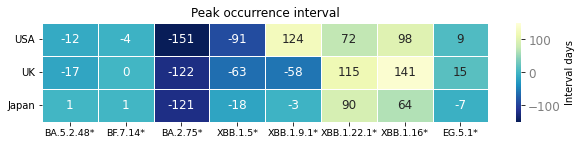

In [14]:
df = pd.read_csv(dirpath+"compare_china_world_GISAID_plot.csv", index_col=0)

#绘制热度图：
font = {'family': 'Times New Roman', 'size': 12}
tick_=np.arange(-150,150,30).astype(float)
dict_={'orientation':'vertical',"label":"color  \
scale","drawedges":True,"ticklocation":"right","extend":"min", \
"filled":True,"alpha":0.8,"cmap":"cmap","ticks":tick_,"spaci,linewidths=0.5ng":'proportional'}
fig = plt.figure(figsize = (10, 4))
ax=fig.add_subplot(2,1,1)
cmap = sns.heatmap(df,linewidths=0.8,annot=True,fmt="d",cmap='YlGnBu_r',annot_kws=font, vmin=-150,vmax=150, center=0)

plt.title("Peak occurrence interval",size=12)

# 旋转轴刻度上文字方向
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0,size = 9.5)

#调整色带的标签：
cbar = cmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=12,labelcolor="grey")
cbar.ax.set_ylabel(ylabel="Interval days",size=10,color="black",loc="center")
fig.savefig(dirpath+"compare_china_world_GISAID_intervaldays.pdf")

plt.show()

In [15]:
df_lin_example  = pd.read_csv(dirpath+'Qualified_world_china_meta_merged_202212_202310.txt')
top8_lineages = ['BA.5.2.48*', 'BF.7.14*', 'BA.2.75*', 'XBB.1.5*', 'XBB.1.9.1*', 'XBB.1.22.1*', 'XBB.1.16*', 'EG.5.1*']
df_lin_example = df_lin_example[df_lin_example["merged_lineage"].isin(top8_lineages)]
all_country = ["USA","UK","Japan","China"] #set(list(df_lin_example.country))

from datetime import *
 
def date_diff(date1, date2):
    return (date2 - date1).days


country_lin_peakdays = {}
for coun in all_country:
    country_lin_peakdays[coun] = {}

for coun in all_country:
    df_temp0 = df_lin_example[df_lin_example["country"] == coun]
    for lin in top8_lineages:
        df_temp1 = df_temp0[df_temp0["merged_lineage"] == lin]
        df_temp1.sort_values(by="date", inplace=True)
        all_index=  df_temp1["date"].tolist()
        d1 = all_index[int(df_temp1.shape[0]*0.25)]
        d2 = all_index[int(df_temp1.shape[0]*0.75)]
        date1 = datetime.strptime(d1, "%Y-%m-%d")
        date2 = datetime.strptime(d2, "%Y-%m-%d")
        interval_days = date_diff(date1,date2)
        country_lin_peakdays[coun][lin] = interval_days
        # break
    # break


df_peak_period = pd.DataFrame(columns = top8_lineages,index = list(all_country))
for i in df_peak_period.index:
    for j in list(df_peak_period):
        df_peak_period.loc[i,j] = country_lin_peakdays[i][j]

df_peak_period = pd.DataFrame(df_peak_period, dtype="int")
df_peak_period.to_csv(dirpath+"compare_china_world_GISAID_period_plot.csv")

/tmp/ipykernel_191690/3411451292.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp1.sort_values(by="date", inplace=True)


In [16]:
df_peak_period

,BA.5.2.48*,BF.7.14*,BA.2.75*,XBB.1.5*,XBB.1.9.1*,XBB.1.22.1*,XBB.1.16*,EG.5.1*
USA,13,15,52,61,114,59,65,36
UK,35,0,56,40,74,78,67,37
Japan,12,25,70,73,93,52,76,44
China,59,67,43,30,32,60,38,60


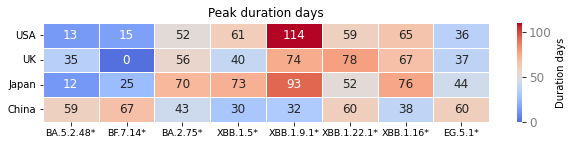

In [17]:
# df_peak_period = pd.read_csv(dirpath+"compare_china_world_GISAID_period_plot.csv",index_col = 0)
df_heatmap_plot = pd.DataFrame(df_peak_period, dtype="int")

#绘制热度图
font = {'family': 'Times New Roman', 'size': 12}
fig = plt.figure(figsize = (10, 4))
ax=fig.add_subplot(2,1,1)
cmap = sns.heatmap(df_heatmap_plot,linewidths=0.8,fmt="d",annot=True,cmap='coolwarm',annot_kws=font, vmin=0,vmax=110, center=50)
plt.title("Peak duration days",size=12)

# 旋转轴刻度上文字方向的
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0,size = 9.5)

#调整色带的标签：
cbar = cmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=12,labelcolor="grey")
cbar.ax.set_ylabel(ylabel="Duration days",size=10,color="black",loc="center")
plt.savefig(dirpath+"compare_china_world_GISAID_peakperiod.pdf")

plt.show()

In [18]:
df_peak_period

,BA.5.2.48*,BF.7.14*,BA.2.75*,XBB.1.5*,XBB.1.9.1*,XBB.1.22.1*,XBB.1.16*,EG.5.1*
USA,13,15,52,61,114,59,65,36
UK,35,0,56,40,74,78,67,37
Japan,12,25,70,73,93,52,76,44
China,59,67,43,30,32,60,38,60


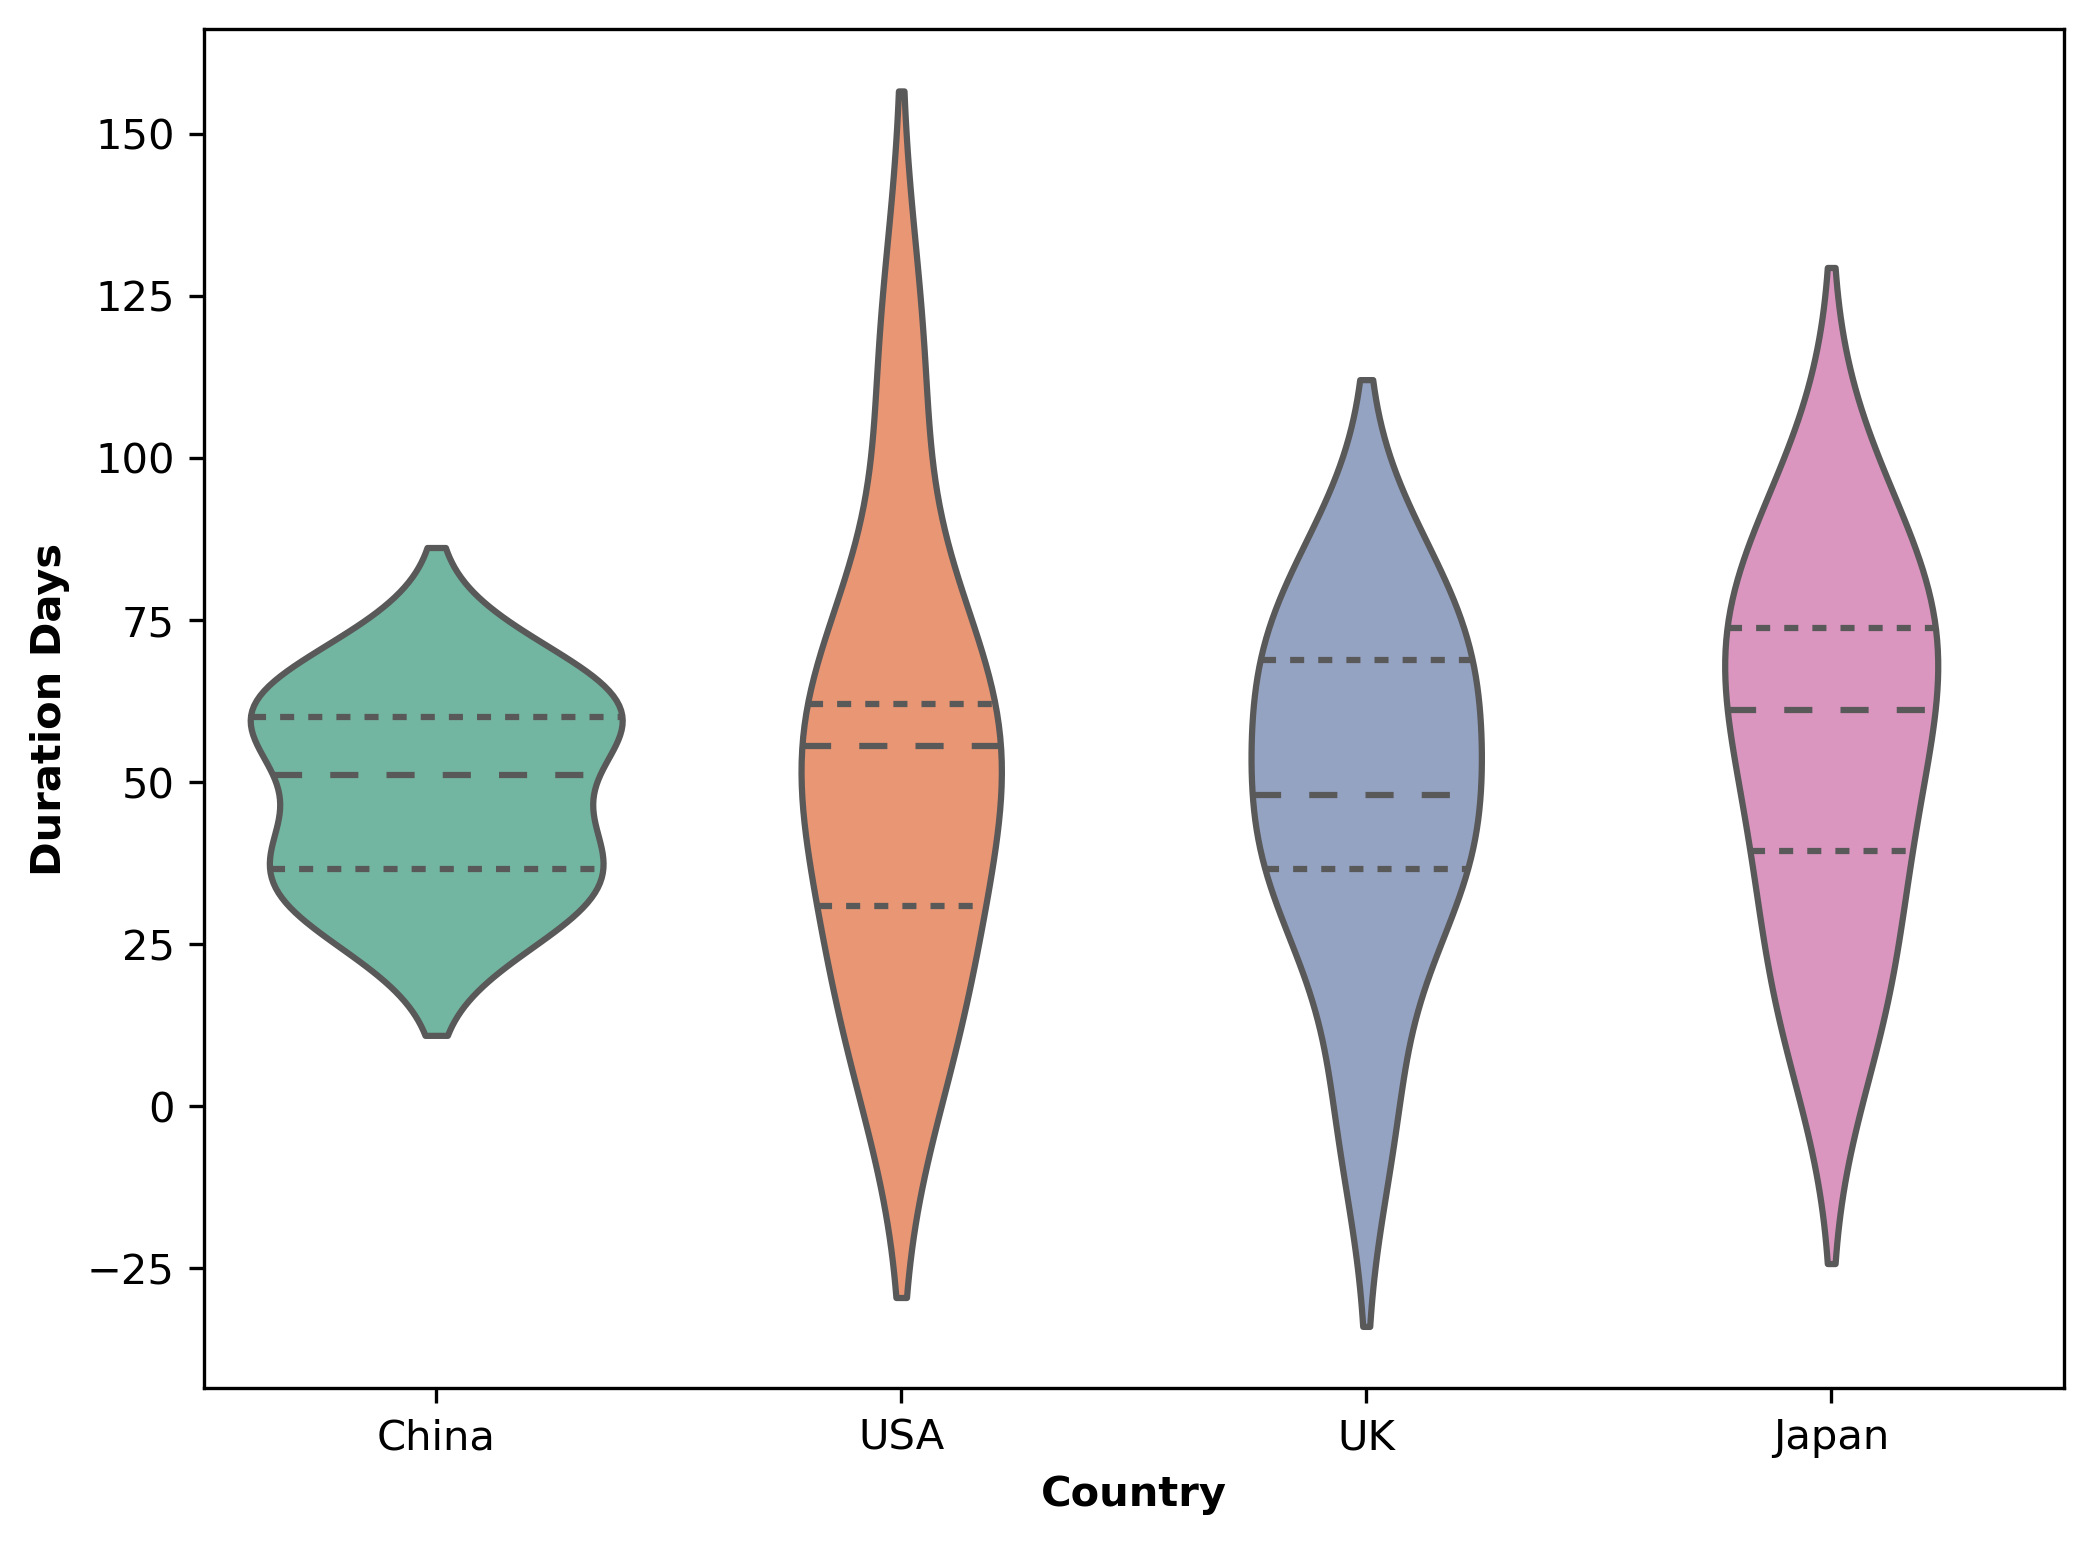

In [19]:
from scipy.stats import ttest_rel
import seaborn as sns
import matplotlib.pyplot as plt

# 创建配对样本数据
China = df_peak_period.loc["China"].tolist()
USA = df_peak_period.loc["USA"].tolist()
UK = df_peak_period.loc["UK"].tolist()
Japan = df_peak_period.loc["Japan"].tolist()
# 创建四组配对样本数据
group_names = ['China', 'USA', 'UK', 'Japan']
data = pd.DataFrame({'China': China, 'USA': USA, 'UK': UK, 'Japan': Japan})

# 进行配对样本T检验并记录P值
pairwise_p_values = {}
for i in range(len(group_names)):
    for j in range(i+1, len(group_names)):
        group1 = data[group_names[i]]
        group2 = data[group_names[j]]
        t_statistic, p_value = ttest_rel(group1, group2)
        pairwise_p_values[f'{group_names[i]}_{group_names[j]}'] = p_value


plt.figure(figsize = [8,6],dpi = 300)
sns.violinplot(x='variable', y='value', data=pd.melt(data), inner='quartile', palette='Set2')
plt.xlabel('Country', weight='bold')
plt.ylabel('Duration Days', weight='bold')

plt.savefig(dirpath+"Durationday.pdf")
plt.show()


In [20]:
country_peirod = df_peak_period.apply(lambda row: row.tolist(), axis=1).to_dict()
country_peirod

{'USA': [13, 15, 52, 61, 114, 59, 65, 36],
 'UK': [35, 0, 56, 40, 74, 78, 67, 37],
 'Japan': [12, 25, 70, 73, 93, 52, 76, 44],
 'China': [59, 67, 43, 30, 32, 60, 38, 60]}

In [21]:
from  scipy.stats import ttest_rel
import pandas as pd

print(ttest_rel(country_peirod["USA"], country_peirod["China"]))
print(ttest_rel(country_peirod["UK"], country_peirod["China"]))
print(ttest_rel(country_peirod["Japan"], country_peirod["China"]))

Ttest_relResult(statistic=0.2069759327926476, pvalue=0.8419206497364555)
Ttest_relResult(statistic=-0.019952739474724004, pvalue=0.9846378966729674)
Ttest_relResult(statistic=0.48544603153825644, pvalue=0.6421847217690795)


In [ ]:
# print("China")
# print(59+43+67+30)
# print(32+38+60+60)

# print("USA")
# print(13+15+52+61)
# print(114+59+65+36)

# print("UK")
# print(35+0+56+40)
# print(74+78+67+37)

# print("Japan")
# print(12+25+70+73)
# print(93+52+76+44)

In [51]:
# import pandas as pd
# from scipy.stats import chi2_contingency

# # 创建一个DataFrame
# data = {'China': [199, 190],
#         'Category2': [131, 256]}
# df = pd.DataFrame(data)

# # 进行卡方检验
# chi2, p, dof, expected = chi2_contingency(df)

# # 输出结果
# print(f"卡方统计量：{chi2}")
# print(f"P值：{p}")
# print(f"自由度：{dof}")
# print("期望频数：")
# print(expected)


卡方统计量：23.071123085953058
P值：1.5611787297550405e-06
自由度：1
期望频数：
[[165.42525773 164.57474227]
 [223.57474227 222.42525773]]
